### GOOGL Models
- Testing different models from linear regression to ...
- **Best model:** `logrModel` (Logistic Regression)
- **Complete?:**

In [49]:
# libraries
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# custom functions
from utils import connect_to_db

# scikit-learn libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sqlalchemy import create_engine
import pandas as pd

In [50]:
# connect to database and get price data

conn = connect_to_db(env="prod")
cursor = conn.cursor()

ticker = 'GOOGL'
data = pd.read_sql_query('''
                               SELECT * FROM public.stocks WHERE ticker = 'GOOGL' ORDER BY date ASC;
                               ''', conn)
data = data.drop(columns=['ticker'])
# price_data = price_data.set_index('date')
data = pd.DataFrame(data)
data
# data.dtypes


/var/folders/6v/kx15yglj19173xqgq1g6f46r0000gn/T/ipykernel_95938/2096440237.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query('''


,id,date,open_price,close_price,high_price,low_price,volume
0,57135,2004-08-19 00:00:00+00:00,2.50,2.51,2.60,2.40,893181924
1,57136,2004-08-20 00:00:00+00:00,2.53,2.71,2.73,2.52,456686856
2,57137,2004-08-23 00:00:00+00:00,2.77,2.74,2.84,2.73,365122512
3,57138,2004-08-24 00:00:00+00:00,2.78,2.62,2.79,2.59,304946748
4,57139,2004-08-25 00:00:00+00:00,2.63,2.65,2.70,2.60,183772044
...,...,...,...,...,...,...,...
5068,15412,2024-10-08 00:00:00+00:00,163.86,163.23,164.73,162.87,12075921
5069,15441,2024-10-09 00:00:00+00:00,163.45,161.86,164.84,159.74,31181800
5070,15442,2024-10-10 00:00:00+00:00,160.87,162.08,163.07,160.40,14010432
5071,15468,2024-10-11 00:00:00+00:00,162.13,163.39,163.84,161.24,6837641


In [51]:

def to_timestamp(date):
    """
    convert date to Unix timestamp
    """
    return date.timestamp()

# one year of future dates (weekdays only)
future_dates = pd.date_range(start=data['date'].iloc[-1], periods=365)
future_dates = future_dates[future_dates.weekday < 5] # remove weekends

# add future dates to data['date'] with null values for all columns
data = pd.concat([data, pd.DataFrame({'date': future_dates})])

data['timestamp'] = data['date'].apply(to_timestamp)

# data.dtypes
data

,id,date,open_price,close_price,high_price,low_price,volume,timestamp
0,57135.0,2004-08-19 00:00:00+00:00,2.50,2.51,2.60,2.40,893181924.0,1.092874e+09
1,57136.0,2004-08-20 00:00:00+00:00,2.53,2.71,2.73,2.52,456686856.0,1.092960e+09
2,57137.0,2004-08-23 00:00:00+00:00,2.77,2.74,2.84,2.73,365122512.0,1.093219e+09
3,57138.0,2004-08-24 00:00:00+00:00,2.78,2.62,2.79,2.59,304946748.0,1.093306e+09
4,57139.0,2004-08-25 00:00:00+00:00,2.63,2.65,2.70,2.60,183772044.0,1.093392e+09
...,...,...,...,...,...,...,...,...
256,NaN,2025-10-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,1.759795e+09
257,NaN,2025-10-08 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,1.759882e+09
258,NaN,2025-10-09 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,1.759968e+09
259,NaN,2025-10-10 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,1.760054e+09


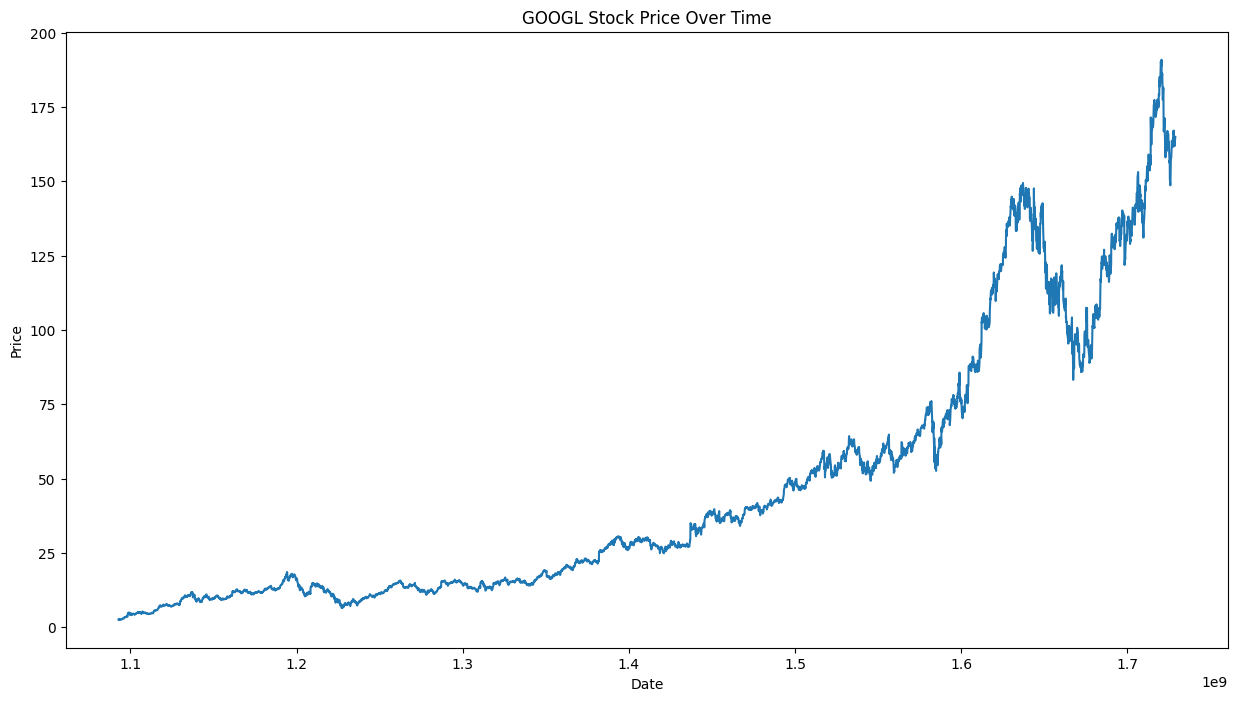

In [52]:
# plot the data
plt.plot(data['timestamp'], data['close_price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Over Time')
# make plot wider
plt.gcf().set_size_inches(15, 8)
plt.show()

### Simple Linear Regression Model

In [53]:
# create the linear regression model

# split data into training and testing data
X = data.dropna()['timestamp']
y = data.dropna()['close_price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

lrModel = LinearRegression(fit_intercept=True)
lrModel.fit(X_train.values.reshape(-1, 1), y_train) 
coefficients = lrModel.coef_
# print(f'Intercept: {lmModel.intercept_}')
print(f'R^2: {lrModel.score(X_train.values.reshape(-1, 1), y_train)}')


R^2: 0.7842311302421918


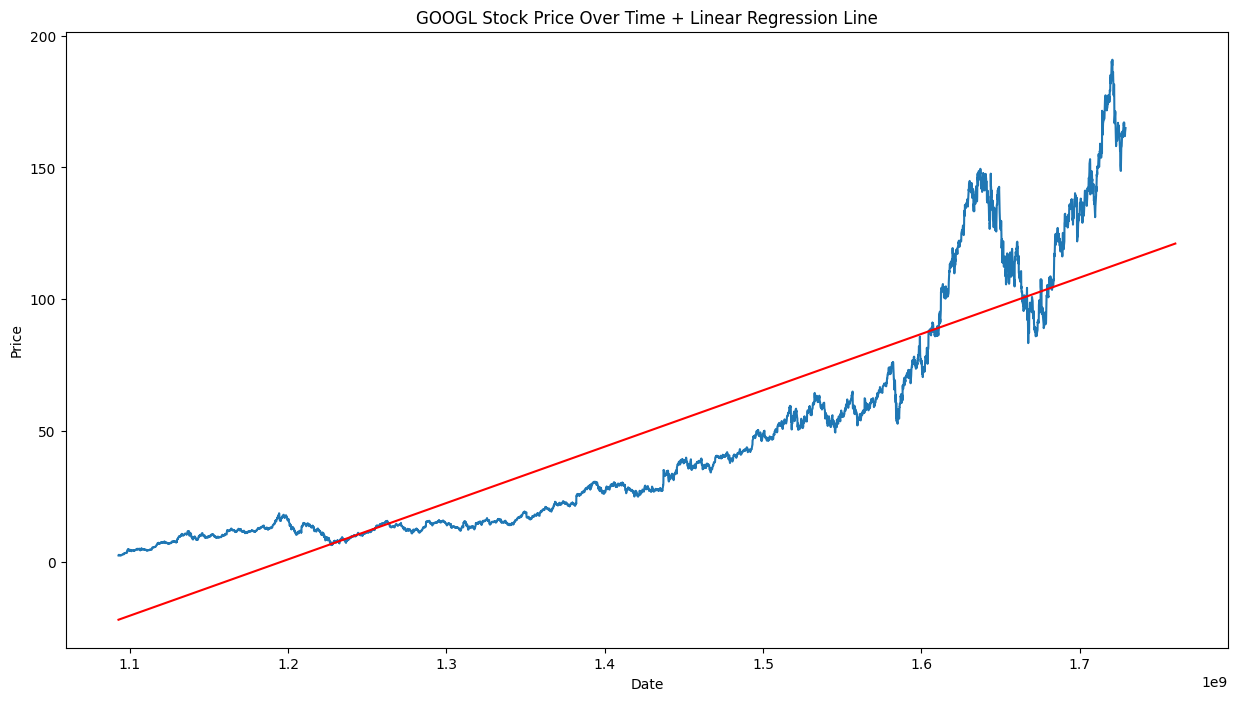

In [54]:
# plot the data with the linear regression line
plt.plot(data['timestamp'], data['close_price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Over Time + Linear Regression Line')
# make plot wider
plt.gcf().set_size_inches(15, 8)

# add the linear regression line
plt.plot(data['timestamp'], lrModel.predict(data['timestamp'].values.reshape(-1, 1)), color='red')

plt.show()


### Quadratic Regression Model

In [55]:
data['timestamp_sq'] = data['timestamp'] ** 2
X = data.dropna()[['timestamp', 'timestamp_sq']]
y = data.dropna()['close_price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

# create the quadratic regression model
qrModel = LinearRegression(fit_intercept=False)
qrModel.fit(X_train, y_train)
coefficients = qrModel.coef_
print(f'R^2: {qrModel.score(X_train, y_train)}')

R^2: 0.8476275010807255


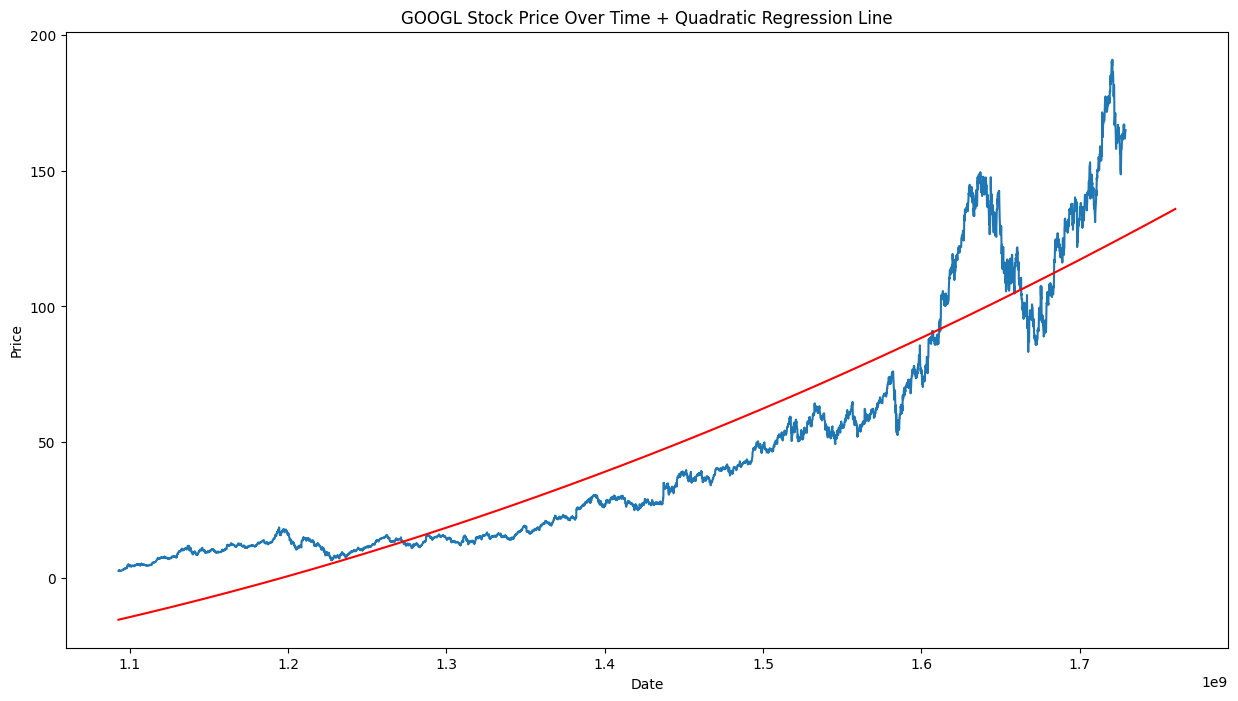

In [56]:
# plot the data with the quadratic regression line
plt.plot(data['timestamp'], data['close_price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Over Time + Quadratic Regression Line')
# make plot wider
plt.gcf().set_size_inches(15, 8)

# add the quadratic regression line
plt.plot(data['timestamp'], qrModel.predict(data[['timestamp', 'timestamp_sq']]), color='red')

plt.show()

### Random Forest Regressor

In [72]:
# creating a random forest regressor model with reduced complexity to avoid overfitting
X = data.dropna()[['timestamp']]
y = data.dropna()['close_price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

rfrModel = RandomForestRegressor(n_estimators=100, random_state=42, max_leaf_nodes=100, max_depth=10, min_samples_split=5)
rfrModel.fit(X_train.values.reshape(-1, 1), y_train)
y_pred = rfrModel.predict(X_valid.values.reshape(-1, 1))
print(f'R^2: {rfrModel.score(X_train.values.reshape(-1, 1), y_train)}')

R^2: 0.999189151624034


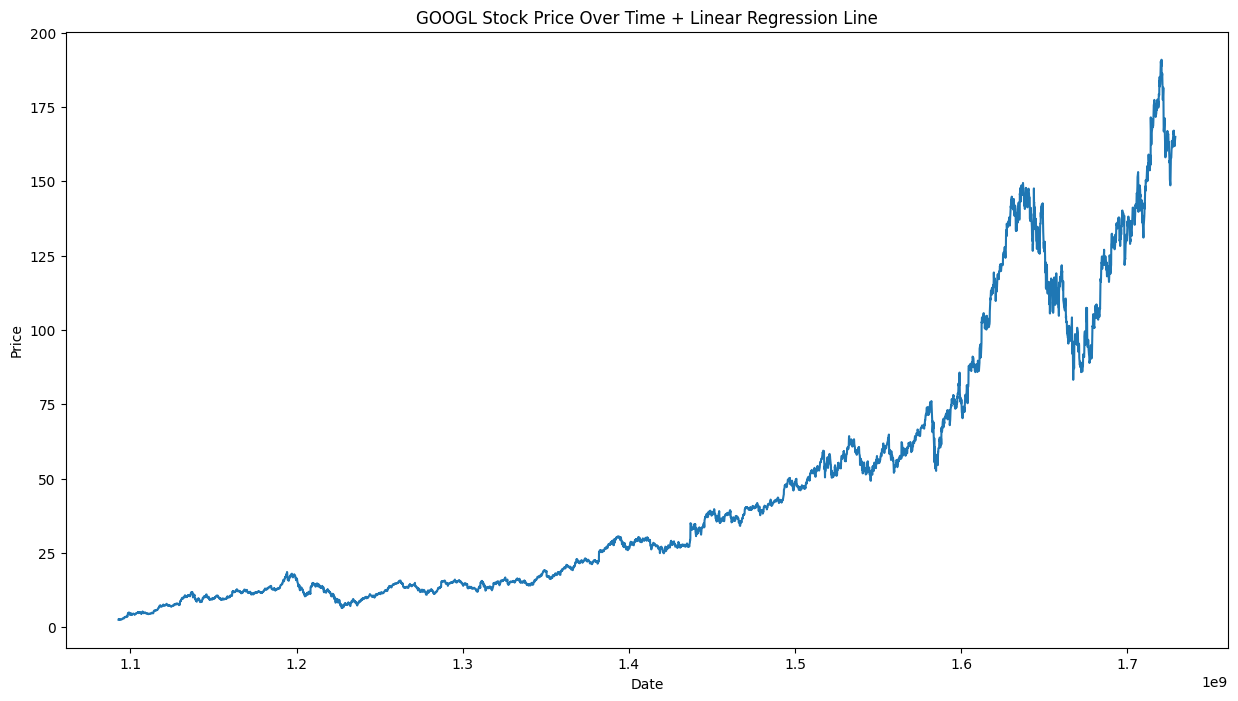

In [76]:
# plot the data with the random forest regressor line
plt.plot(data['timestamp'], data['close_price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Over Time + Linear Regression Line')
# make plot wider
plt.gcf().set_size_inches(15, 8)

# add the random forest regressor line with red for training data and green for validation data


plt.show()

### Random Forest Regressor Model 2 (More Features)

In [60]:
data['timestamp_sq'] = data['timestamp'] ** 2
data['prev_close'] = data['close_price'].shift(1).bfill()
data['weekly_avg'] = data['close_price'].rolling(window=5).mean().bfill()
data['monthly_avg'] = data['close_price'].rolling(window=20).mean().bfill()
data['day_of_week'] = data['date'].dt.dayofweek
data['day_of_month'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['quarter'] = data['date'].dt.quarter

X = data.dropna()[['timestamp', 
                #    'prev_close', 'weekly_avg', 'monthly_avg', 
                   'day_of_week', 'day_of_month', 'month', 
                   'year', 'quarter']]
y = data.dropna()['close_price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

# create the random forest regressor model
rfrModel2 = RandomForestRegressor(n_estimators=100, random_state=42, max_leaf_nodes=100, max_depth=10, min_samples_split=5)
rfrModel2.fit(X_train, y_train)
print(f'R^2: {rfrModel2.score(X_train, y_train)}')

R^2: 0.9991670686008439


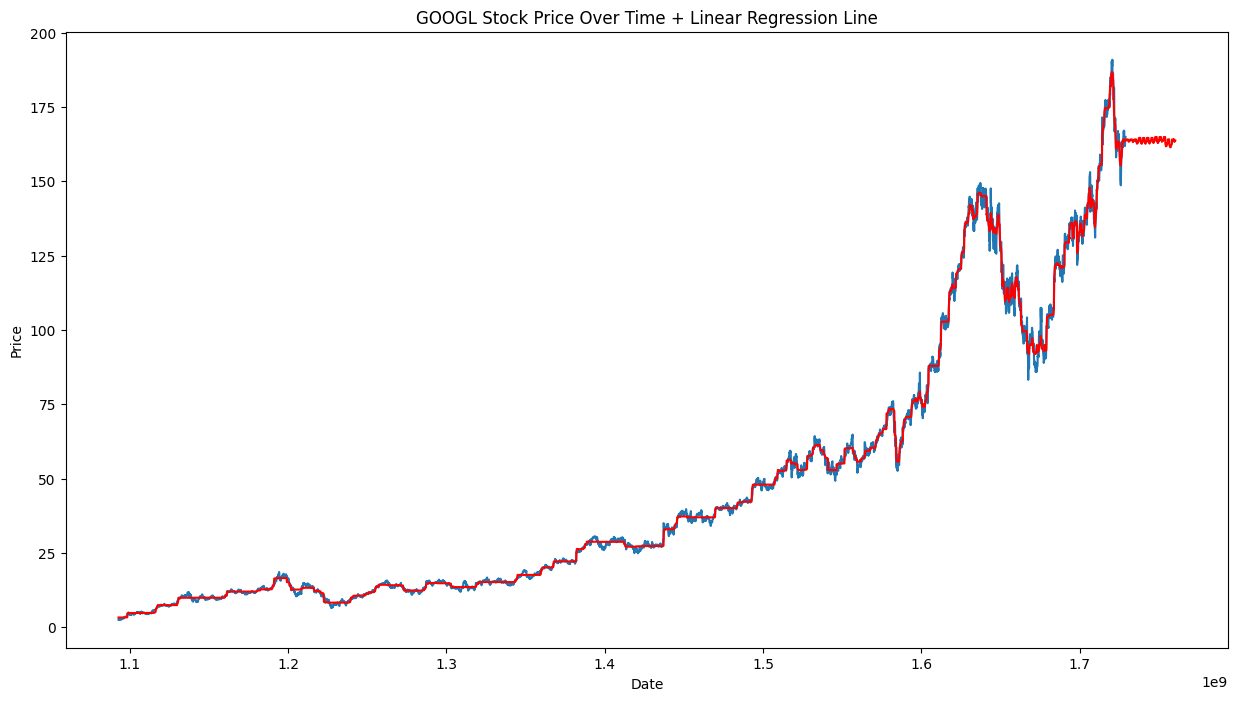

In [61]:
# plot the data with the random forest regressor 2 line
plt.plot(data['timestamp'], data['close_price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Over Time + Linear Regression Line')
# make plot wider
plt.gcf().set_size_inches(15, 8)

# add the random forest regressor line
plt.plot(data['timestamp'], rfrModel2.predict(
    data[['timestamp', 
        #   'prev_close', 'weekly_avg', 'monthly_avg', 
          'day_of_week', 'day_of_month', 'month', 'year', 'quarter']]
), color='red')


plt.show()